In [48]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.api as sms
from sklearn.linear_model import LinearRegression

df = pd.read_csv("data.txt", sep="|")
df.head()
# By inspection of data.txt, the only NAs occur for inflation and interest in 1950 Q1
# data.txt includes complete quarterly data from 1950 Q1 to 2000 Q4 
# with all dates in order and with no missing quarters

,date,gdp,consumption,invest,government,dpi,cpi,m1,tbill,unemp,population,inflation,interest
0,1950 Q1,1610.5,1058.9,198.1,361.0,1186.1,70.6,110.20,1.12,6.4,149.461,NaN,NaN
1,1950 Q2,1658.8,1075.9,220.4,366.4,1178.1,71.4,111.75,1.17,5.6,150.260,4.5071,-3.3404
2,1950 Q3,1723.0,1131.0,239.7,359.6,1196.5,73.2,112.95,1.23,4.6,151.064,9.9590,-8.7290
3,1950 Q4,1753.9,1097.6,271.8,382.5,1210.0,74.9,113.93,1.35,4.2,151.871,9.1834,-7.8301
4,1951 Q1,1773.5,1122.8,242.9,421.9,1207.9,77.3,115.08,1.40,3.5,152.393,12.6160,-11.2160


In [64]:
# Only consumption, dpi and unemp are required for this analysis
# The rest can be dropped, including date labels
# Regression is to be performed on differences of the macroeconomic data values
dconsum = (df.consumption.pct_change())[1:]  # percent changes with leading NaNs removed
ddpi = (df.dpi.pct_change())[1:]
dunemp = (df.unemp.pct_change())[1:]
ddpi.head()

1   -0.006745
2    0.015618
3    0.011283
4   -0.001736
5    0.014819
Name: dpi, dtype: float64

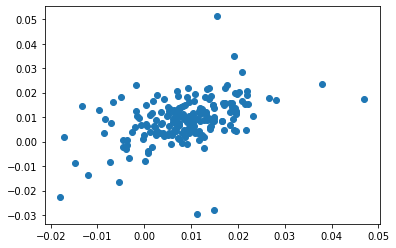

In [65]:
# Visualize consumption vs dpi
fig, ax = plt.subplots()
ax.scatter(ddpi, dconsum)
plt.show()
# A positive correlation is observed

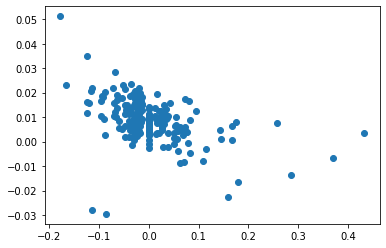

In [66]:
# Visualize consumption vs unemployment
fig, ax = plt.subplots()
ax.scatter(dunemp, dconsum)
plt.show()
# A slight negative correlation can be inferred

In [67]:
# Task 1: Replication of Results 
# Set up regression inputs for statmodels.api
y = pd.DataFrame(dconsum)
X = pd.DataFrame(ddpi)
X['unemp'] = dunemp
X = sm.add_constant(X) ## Add an intercept (beta_0) to the model


In [68]:
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

# Note that regression coefficients, standard errors, t-statistics, and p-values 
# match given values from the coding exercise.
# The R-squared result of 33.5% does not indicate a good fit.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            consumption   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     41.11
Date:                Thu, 14 Jul 2022   Prob (F-statistic):           1.10e-15
Time:                        17:42:51   Log-Likelihood:                 705.58
No. Observations:                 203   AIC:                            -1405.
Df Residuals:                     200   BIC:                            -1395.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0062      0.001      8.099      0.000       0.005       0.008
dpi            0.3176      0.064      4.934      0.000       0.191       0.444
unemp         -0.0399      0.008     -5.323      0.000      -0.055      -0.025
==============================================================================
Omnibus:                       89.203   Durbin-Watson:                   2.469
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1037.771
Skew:                          -1.315   Prob(JB):                    4.48e-226
Kurtosis:                      13.760   Cond. No.                         122.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [69]:
# Now fit using scikit-learn
reg = LinearRegression().fit(X, y)
reg.score(X, y)
# 29.1% matches the statmodels result

0.29135603560658974

In [70]:
reg.coef_
# Coefficients match statmodels and coding exercise results

array([[ 0.        ,  0.31757389, -0.0399227 ]])

In [71]:
reg.intercept_
# Intercept matches statmodels and coding exercise results


array([0.00619107])

In [72]:
# Conclusions for Task 1: 
# Results of the regression estimation using own implementations verify
# Regression accuracy evaluation: Accuracy is low as indicated by the 33.5% R-squared

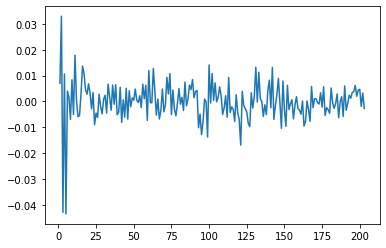

In [73]:
# Task 2: Outlier Detections
# Examine the time series of residuals
predictions = reg.predict(X)
residuals = (y - predictions)

# Plot the residuals time series
fig, ax = plt.subplots()
ax.plot(residuals)
plt.show()

In [74]:
# Use Tukeys test
Q1 = np.percentile(residuals, 25, interpolation = 'midpoint')  # First quartile (Q1)
Q2 = np.percentile(residuals, 50, interpolation = 'midpoint')  # Median (Q2)
Q3 = np.percentile(residuals, 75, interpolation = 'midpoint')  # Third quartile (Q3)
IQR = Q3 - Q1  # Interquaritle range (IQR)
Tlower = Q1 - 1.5*IQR  # Tukey lower bound
Tupper = Q3 + 1.5*IQR  # Tukey upper bound
print(Q1, Q2, Q3, IQR, Tlower, Tupper)

-0.0037726254742414846 -0.00010900747153463203 0.004023615554931867 0.007796241029173352 -0.015466987018001511 0.015717977098691896


In [75]:
# Counts of outliers
r = np.array(residuals)  # Use numpy array for count functionality
l = np.count_nonzero(r < Tlower)  # Count of lower outliers
u = np.count_nonzero(r > Tupper)  # Count of upper outliers
n = len(r)  # number of elements in the dataset
print(l, u, n)

3 2 203


In [76]:
# Conclusions for Task 2
# There are 5 outliers in the dataset with 203 elements, representing 2.4% of the data
# The outliers are balanced upper side and lower: 2 upper and 3 lower.
# All 5 outliers occur at the beginning of the dataset

# The cause of this problem is that consumption and dpi figures increase exponentially 
# over the 50 year period, and so differences between quarters grow over time.
# It is more appropriate to do the analysis with log returns or percent returns
# rather than differences, in order to remove this bias.

In [77]:
# Test 3: Autocorrelation of Residuals
# Calculate the Durbin-Watson (DW) statistic of the residuals

# Quarterly differences of residuals
dresiduals = (residuals - residuals.shift())[1:]

ssd = (dresiduals**2).sum()  # Sum of squares of residual differences
ssr = (residuals**2).sum()   # Sum of the squared residuals

# DW statistic
DW = float( ssd / ssr )
print(DW)

2.4692581187985394


In [78]:
# Conclusions for Test 3
# The value of 2.47 is above 2, which indicates negative autocorrelation.
# However, values between 1.5 and 2.5 are considered acceptable.
# Therefore, autocorrelation in the residuals does not lead to significant
# undervaluation of the standard error in this analysis.

In [79]:
# Task 4: Bootstapping of Standard Errors
# Recalculate the standard errors of the regression coefficients using bootstrapping.

# Standard error is defined as the square root of the sum of the squares of the residuals
# divided by the number of samples

# Standard error for the current dataset
SE = float( math.sqrt(ssr / n) )
print(SE)

0.0074861185162734285


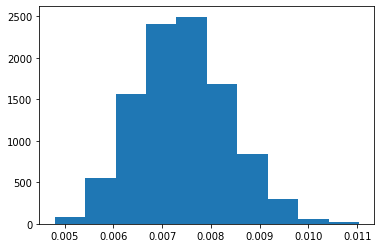

In [80]:
# Generate bootstrap samples and calculate standard errors
from sklearn.utils import resample
n_bootstraps = 10000
sample_SEs = []

for _ in range(n_bootstraps):
    boot = resample(residuals, replace=True)
    ssr = (boot**2).sum()     # Sum of the squared residuals
    sse = math.sqrt(ssr / n)  # Sample standard error
    sample_SEs.append(sse)    # Append to output array
    
sample_SEs = np.array(sample_SEs)  # Use numpy array for stats functionality
mean_SEs = sample_SEs.mean()

# Histogram the bootstrapped standard errors
fig, ax = plt.subplots()
ax.hist(sample_SEs)
plt.show()

In [81]:
sample_SEs = np.array(sample_SEs)  # Use numpy array for stats functionality
mean_SEs = sample_SEs.mean()

print(SE, mean_SEs)

# According to the Central Limit theorem, the distribution is expected to tend to a normal
# as the sample size increase, and indeed this distribution appears normal.

# According to Michael Grogan, https://medium.com/p/b112bb4a969e, "a primary use of 
# bootstrapping is to estimate the confidence interval of the population mean."
# 
sms.DescrStatsW(sample_SEs).tconfint_mean()


0.0074861185162734285 0.007420221603023956


(0.007401960177713567, 0.0074384830283343445)